    horizon: 1hour
   size: 12 samples (1.0 hours)
 288 samples

 data from 'merged_5min_spline_interpolated.csv'
   Total samples: 16089
    range: 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00

 data split:
   training samples: 15801
   testing samples: 288
network structures with 1-10 neurons per layer
   total architectures to test: 1110
check: 100/1110 (9.0%)
check: 200/1110 (18.0%)
check: 300/1110 (27.0%)
check: 400/1110 (36.0%)
check: 500/1110 (45.0%)
check: 600/1110 (54.1%)
check: 700/1110 (63.1%)
check: 800/1110 (72.1%)
check: 900/1110 (81.1%)
check: 1000/1110 (90.1%)
check: 1100/1110 (99.1%)

 best architecture found: [5, 7, 8]
   MAE: 0.3326 °C
   RMSE: 0.6012 °C
   R²: 0.6576

 top10 architectures:
Architecture      MAE     RMSE       R²
   [5, 7, 8] 0.332579 0.601247 0.657601
   [9, 6, 3] 0.376431 0.590742 0.669461
   [9, 9, 3] 0.391021 0.614442 0.642408
  [10, 7, 9] 0.391426 0.601869 0.656892
  [8, 10, 5] 0.393436 0.618615 0.637534
   [9, 7, 1] 0.401056 0.688520 

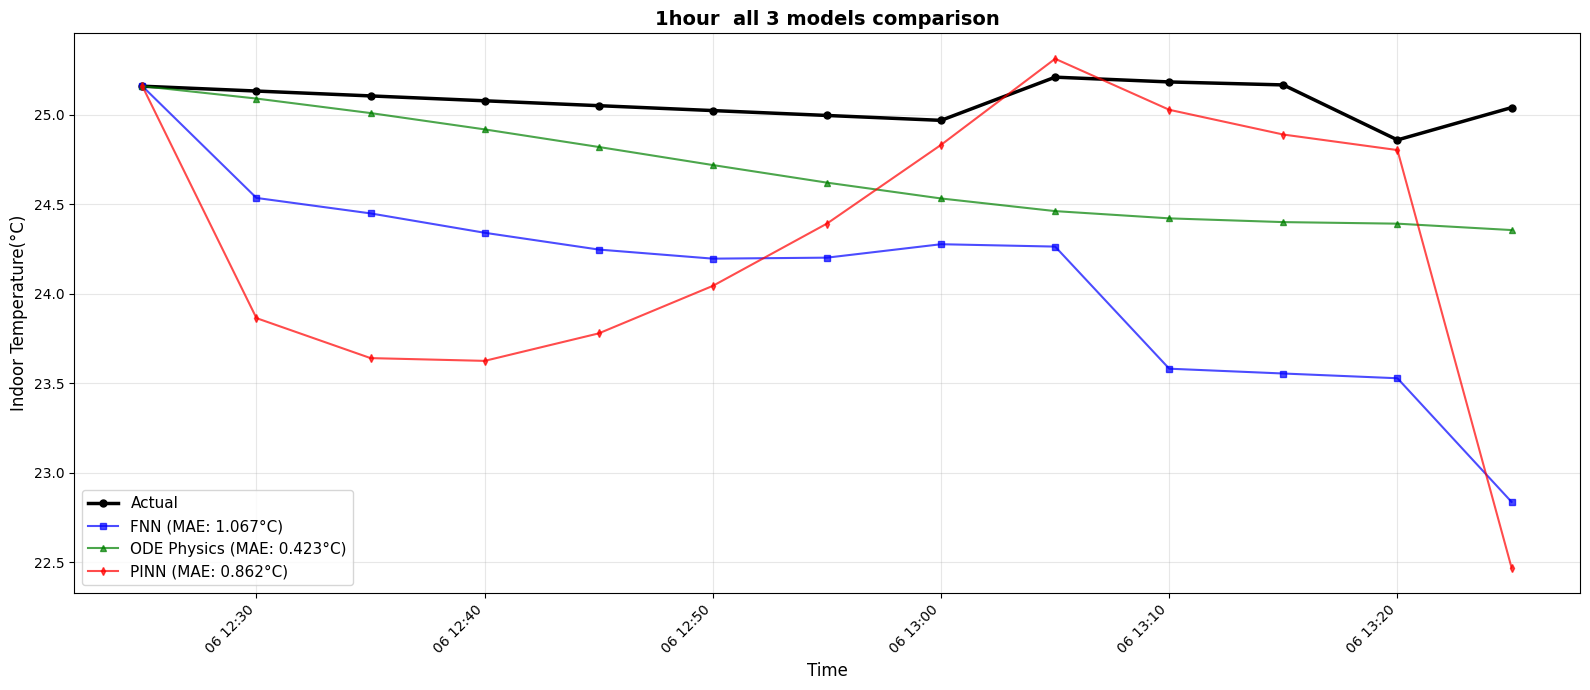

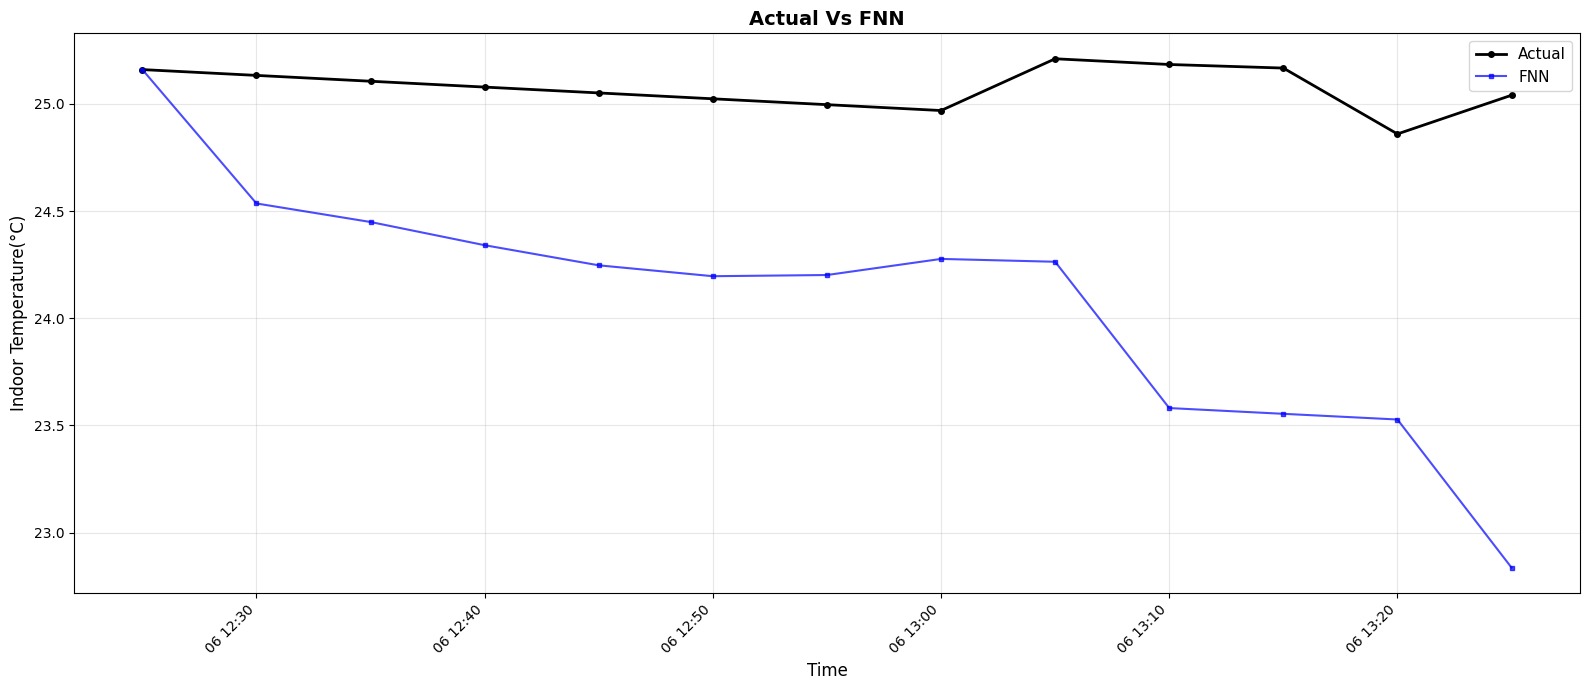

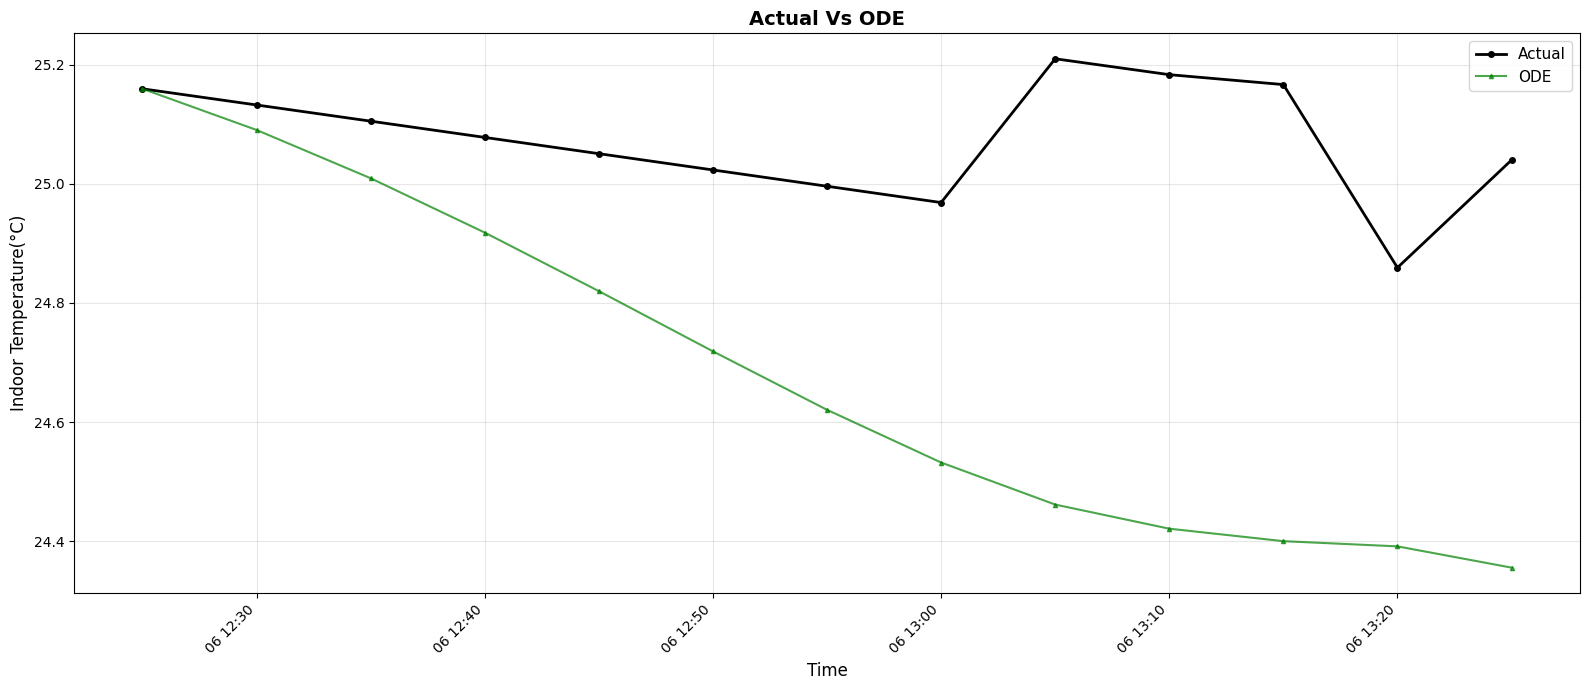

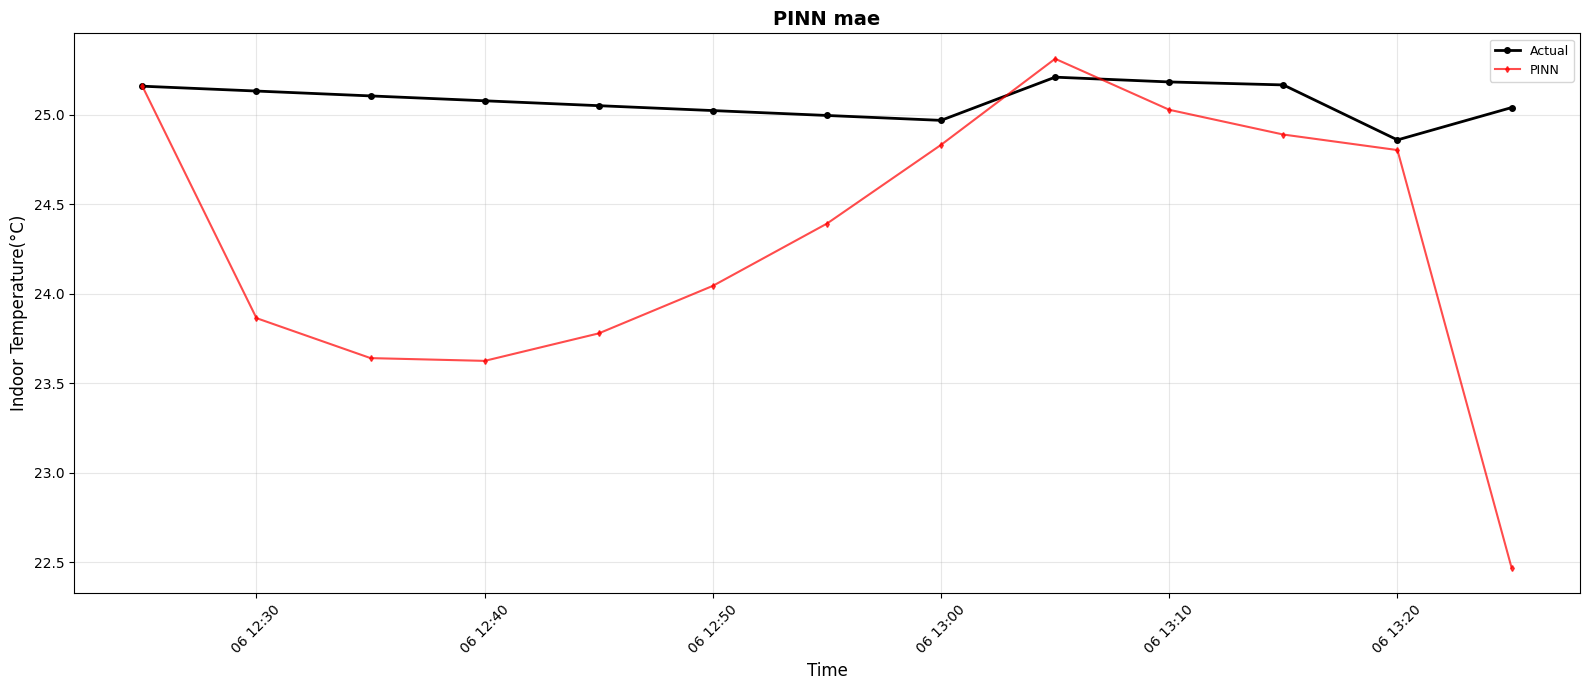

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


PREDICTION_HORIZON = '1hour'  


DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0  
TEST_DAYS = 1            

# for again having the same result
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)
plt.rcParams["figure.figsize"] = (14, 5)

SAMPLES_PER_DAY = int(24 * 60 / TIME_STEP_MINUTES)  

if PREDICTION_HORIZON == '1hour':
    WINDOW_SAMPLES = 12      
    WINDOW_NAME = "1hour"
elif PREDICTION_HORIZON == '6hour':
    WINDOW_SAMPLES = 72      
    WINDOW_NAME = "6hour"
elif PREDICTION_HORIZON == '12hour':
    WINDOW_SAMPLES = 144   
    WINDOW_NAME = "12hour"
else:
    raise ValueError("1,6,12 only")

TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

print(f"    horizon: {WINDOW_NAME}")
print(f"   size: {WINDOW_SAMPLES} samples ({WINDOW_SAMPLES * TIME_STEP_MINUTES / 60:.1f} hours)")
print(f" {TEST_SIZE} samples")

print(f"\n data from '{DATA_FILE}'")

try:

    full_data = pd.read_csv(DATA_FILE)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)
    
    required_columns = ["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]
    full_data = full_data.dropna(subset=required_columns).reset_index(drop=True)
      

    print(f"   Total samples: {len(full_data)}")
    print(f"    range: {full_data['time'].min()} to {full_data['time'].max()}")
    
except FileNotFoundError:
    print(f" ERROR: File '{DATA_FILE}' not found!")
    print(f"   Please make sure the file is in the same folder as this script.")
    raise
except Exception as e:
    print(f" ERROR loading data: {e}")
    raise

train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)# all row except last test size
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)#only the last test sizes rows

print(f"\n data split:")
print(f"   training samples: {len(train_data)}")
print(f"   testing samples: {len(test_data)}")

def calculate_r2_safe(y_true, y_pred):
    
    r2 = r2_score(y_true, y_pred)
    return max(-1.0, min(1.0, r2))

def prepare_one_step_data(df):
    inputs = df[["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]].shift(1)
    inputs = inputs.iloc[1:].values 
    
    targets = df["indoor_temp"].iloc[1:].values.reshape(-1, 1)
    return inputs, targets

def unscale_predictions(scaled_values, scaler):
    is_tensor = isinstance(scaled_values, torch.Tensor)
    
    if is_tensor:
        scale = torch.tensor(scaler.scale_[0], dtype=torch.float32)
        center = torch.tensor(scaler.center_[0], dtype=torch.float32)
        return scaled_values * scale + center
    else:
        return scaled_values * scaler.scale_[0] + scaler.center_[0]


train_inputs_np, train_targets_np = prepare_one_step_data(train_data)
test_inputs_np, test_targets_np = prepare_one_step_data(test_data)


input_scaler = RobustScaler()
target_scaler = RobustScaler()

train_inputs_scaled = input_scaler.fit_transform(train_inputs_np)
test_inputs_scaled = input_scaler.transform(test_inputs_np)
train_targets_scaled = target_scaler.fit_transform(train_targets_np)

train_inputs_tensor = torch.tensor(train_inputs_scaled, dtype=torch.float32)
train_targets_tensor = torch.tensor(train_targets_scaled, dtype=torch.float32)
test_inputs_tensor = torch.tensor(test_inputs_scaled, dtype=torch.float32)
test_targets_tensor = torch.tensor(test_targets_np, dtype=torch.float32)


# my Fnnn model
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super().__init__()
        layers = []
        current_dim = input_dim
        for hidden_dim in hidden_layer_sizes:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())  
            current_dim = hidden_dim
            
        layers.append(nn.Linear(current_dim, 1)) #outleyer
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


print(f"network structures with 1-10 neurons per layer")


all_architectures = []
neuron_options = list(range(1, 11))  
for n1 in neuron_options:
    all_architectures.append([n1])
for n1 in neuron_options:
    for n2 in neuron_options:
        all_architectures.append([n1, n2])
for n1 in neuron_options:
    for n2 in neuron_options:
        for n3 in neuron_options:
            all_architectures.append([n1, n2, n3])

print(f"   total architectures to test: {len(all_architectures)}")

# check all architecture
mse_loss = nn.MSELoss()
all_results = []
progress_interval = 100

for idx, hidden_layers in enumerate (all_architectures, start=1):
    # training my FNN model
    model = SimpleNeuralNetwork(train_inputs_tensor.shape[1], hidden_layers)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    
    # my early stoping perametrs
    best_val_loss = float("inf")
    best_state = None
    patience = 15
    no_improve_count = 0
    for epoch in range(300):
        model.train()
        optimizer.zero_grad()
        pred_scaled = model(train_inputs_tensor)
        pred_real = unscale_predictions(pred_scaled, target_scaler).view(-1)
        targets_real = unscale_predictions(train_targets_tensor, target_scaler).view(-1)
        loss = mse_loss(pred_real, targets_real)
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            val_pred_scaled = model(test_inputs_tensor)
            val_pred_real = unscale_predictions(val_pred_scaled, target_scaler).view(-1)
            val_targets = test_targets_tensor.view(-1)
            val_loss = mse_loss(val_pred_real, val_targets).item()
        
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                break
    
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        final_pred = unscale_predictions(model(test_inputs_tensor), target_scaler).ravel()
    
    mae = mean_absolute_error(test_targets_np.ravel(), final_pred)
    rmse = np.sqrt(mean_squared_error(test_targets_np.ravel(), final_pred))
    r2 = calculate_r2_safe(test_targets_np.ravel(), final_pred)
    
    all_results.append({
        "architecture": hidden_layers,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "state_dict": best_state if idx <= 50 else None
    })
    
    if idx % progress_interval == 0:
        percent = 100.0 * idx / len(all_architectures)
        print(f"check: {idx}/{len(all_architectures)} ({percent:.1f}%)")

# check results for best architecture
results_df = pd.DataFrame([{
    "Architecture": str(r["architecture"]),
    "MAE": r["mae"],
    "RMSE": r["rmse"],
    "R²": r["r2"]
} for r in all_results])

best_idx = results_df["MAE"].idxmin()
best_result = all_results[best_idx]
best_architecture = best_result["architecture"]


print(f"\n best architecture found: {best_architecture}")
print(f"   MAE: {best_result['mae']:.4f} °C")
print(f"   RMSE: {best_result['rmse']:.4f} °C")
print(f"   R²: {best_result['r2']:.4f}")


print(f"\n top10 architectures:")
print(results_df.nsmallest(10, "MAE").to_string(index=False))


final_fnn = SimpleNeuralNetwork(train_inputs_tensor.shape[1], best_architecture)

if best_result["state_dict"] is None:
    print(f"   Retraining architecture {best_architecture}...")
    optimizer = torch.optim.AdamW(final_fnn.parameters(), lr=1e-3)
    best_val_loss = float("inf")
    best_state = None
    patience = 15
    no_improve_count = 0
    
    for epoch in range(300):
        final_fnn.train()
        optimizer.zero_grad()
        pred_scaled = final_fnn(train_inputs_tensor)
        pred_real = unscale_predictions(pred_scaled, target_scaler).view(-1)
        targets_real = unscale_predictions(train_targets_tensor, target_scaler).view(-1)
        loss = mse_loss(pred_real, targets_real)
        loss.backward()
        optimizer.step()
        
        final_fnn.eval()
        with torch.no_grad():
            val_pred = unscale_predictions(final_fnn(test_inputs_tensor), target_scaler).view(-1)
            val_loss = mse_loss(val_pred, test_targets_tensor.view(-1)).item()
        
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.clone() for k, v in final_fnn.state_dict().items()}
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                break
    
    best_result["state_dict"] = best_state

# load best weight
final_fnn.load_state_dict(best_result["state_dict"])
final_fnn.eval()
with torch.no_grad():
    fnn_predictions = unscale_predictions(final_fnn(test_inputs_tensor), target_scaler).ravel()
    
fnn_mae = mean_absolute_error(test_targets_np.ravel(), fnn_predictions)
fnn_rmse = np.sqrt(mean_squared_error(test_targets_np.ravel(), fnn_predictions))
fnn_r2 = calculate_r2_safe(test_targets_np.ravel(), fnn_predictions)

print(f"FNN ")
print(f"MAE:{fnn_mae:.4f} °C")
print(f"RMSE:{fnn_rmse:.4f} °C")
print(f"R²:{fnn_r2:.4f}")


# my physics peramiters
indoor_temps = torch.tensor(train_data["indoor_temp"].values, dtype=torch.float32)
supply_temps = torch.tensor(train_data["supply_air"].values, dtype=torch.float32)
outdoor_temps = torch.tensor(train_data["outdoor_temp"].values, dtype=torch.float32)
solar_radiation = torch.tensor(train_data["satellite_value"].values, dtype=torch.float32)

dT_dt_measured = (indoor_temps[1:] - indoor_temps[:-1]) / TIME_STEP_MINUTES

theta = nn.Parameter(torch.tensor([0.0, 0.0, 0.0, 1.0], dtype=torch.float32))
optimizer_physics = torch.optim.Adam([theta], lr=1e-2)


for step in range(500):
    
    C = torch.abs(theta[3]) + 0.1
  
    dT_dt_physics = (
        theta[0] * (supply_temps[:-1] - indoor_temps[:-1]) +
        theta[1] * (indoor_temps[:-1] - outdoor_temps[:-1]) +
        theta[2] * solar_radiation[:-1]  
    
    ) / C
    
    loss = torch.mean((dT_dt_physics - dT_dt_measured) ** 2)
    optimizer_physics.zero_grad()
    loss.backward()
    optimizer_physics.step()

theta_learned = theta.detach()

print(f"   θ₀ (supply air effect): {theta_learned[0].item():.6f}")
print(f"   θ₁ (outdoor effect): {theta_learned[1].item():.6f}")
print(f"   θ₂ (solar effect): {theta_learned[2].item():.6f}")


#my physicses  model is here
def simulate_temperature(initial_temp, drivers, theta_params, dt=TIME_STEP_MINUTES):
    num_steps = drivers.shape[0]
    temps = np.zeros(num_steps + 1)
    temps[0] = initial_temp
    
    C = abs(theta_params[3])
    
    for t in range(num_steps):
        T_supply, T_out, Phi = drivers[t]
        T_current = temps[t]
        
        
        dT_dt = (
            theta_params[0] * (T_supply - T_current) +
            theta_params[1] * (T_current - T_out) +
            theta_params[2] * Phi
        ) / C
        
       
        temps[t + 1] = T_current + dt * dT_dt
    
    return temps[1:]

test_drivers = test_data[["supply_air", "outdoor_temp", "satellite_value"]].values
initial_temp = test_data["indoor_temp"].iloc[0]

ode_predictions = simulate_temperature(
    initial_temp=initial_temp,
    drivers=test_drivers[:-1],
    theta_params=theta_learned.cpu().numpy()
)


ode_mae = mean_absolute_error(test_targets_np.ravel(), ode_predictions)
ode_rmse = np.sqrt(mean_squared_error(test_targets_np.ravel(), ode_predictions))
ode_r2 = calculate_r2_safe(test_targets_np.ravel(), ode_predictions)

print(f" ODE ")
print(f"   test mae: {ode_mae:.4f} °C")
print(f"   test rmse: {ode_rmse:.4f} °C")
print(f"   test R²: {ode_r2:.4f}")


#PINNS
def calculate_physics_loss(predictions, drivers, theta_params, dt=TIME_STEP_MINUTES):
    supply = torch.tensor(drivers[:, 0], dtype=torch.float32)
    outdoor = torch.tensor(drivers[:, 1], dtype=torch.float32)
    solar = torch.tensor(drivers[:, 2], dtype=torch.float32)
    
    C = torch.abs(theta_params[3]) + 0.1
    
    # Temperature change from predictions
    dT_dt_pred = (predictions[1:] - predictions[:-1]) / dt
    
    # Temperature change from physics
    dT_dt_phys = (
        theta_params[0] * (supply[:-1] - predictions[:-1]) +
        theta_params[1] * (predictions[:-1] - outdoor[:-1]) +
        theta_params[2] * solar[:-1]
    ) / C
    
    return mse_loss(dT_dt_pred, dT_dt_phys)

# pinn with best FNN
pinn_model = SimpleNeuralNetwork(train_inputs_tensor.shape[1], best_architecture)
pinn_model.load_state_dict(best_result["state_dict"])
theta_pinn = nn.Parameter(theta_learned.clone())
optimizer_pinn = torch.optim.AdamW(list(pinn_model.parameters()) + [theta_pinn],lr=5e-4)

# physic.weight
initial_physics_weight = 0.3
final_physics_weight = 0.05
data_weight = 1.0
num_epochs = 400

best_pinn_val_loss = float("inf")
best_pinn_state = None
best_theta_pinn = None
patience = 20
no_improve_count = 0

train_drivers = train_data[["supply_air", "outdoor_temp", "satellite_value"]].values[1:]

print(f" {num_epochs} ")

for epoch in range(num_epochs):
    pinn_model.train()
    optimizer_pinn.zero_grad()
    progress = epoch / num_epochs
    physics_weight = initial_physics_weight * (1 - progress) + final_physics_weight * progress
    

    pred_scaled = pinn_model(train_inputs_tensor)
    pred_real = unscale_predictions(pred_scaled, target_scaler).view(-1)
    targets_real = unscale_predictions(train_targets_tensor, target_scaler).view(-1)
    
    loss_data = mse_loss(pred_real, targets_real)
    loss_physics = calculate_physics_loss(pred_real, train_drivers, theta_pinn)
    total_loss = data_weight * loss_data + physics_weight * loss_physics
    
    total_loss.backward()
    optimizer_pinn.step()
    

    pinn_model.eval()
    with torch.no_grad():
        val_pred = unscale_predictions(pinn_model(test_inputs_tensor), target_scaler).view(-1)
        val_loss = mse_loss(val_pred, test_targets_tensor.view(-1)).item()
    
    
    if val_loss < best_pinn_val_loss - 1e-6:
        best_pinn_val_loss = val_loss
        best_pinn_state = {k: v.clone() for k, v in pinn_model.state_dict().items()}
        best_theta_pinn = theta_pinn.clone()
        no_improve_count = 0
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"   Early stopping at epoch {epoch+1}")
            break
    
    
    if (epoch + 1) % 50 == 0:
        print(f"   Epoch {epoch+1:3d} | Data loss: {loss_data.item():.4f} | "
              f"Physics loss: {loss_physics.item():.4f} | Physics weight: {physics_weight:.3f}")


pinn_model.load_state_dict(best_pinn_state)
theta_pinn = best_theta_pinn
pinn_model.eval()
with torch.no_grad():
    pinn_predictions = unscale_predictions(pinn_model(test_inputs_tensor), target_scaler).ravel()

# Calculate metrics
pinn_mae = mean_absolute_error(test_targets_np.ravel(), pinn_predictions)
pinn_rmse = np.sqrt(mean_squared_error(test_targets_np.ravel(), pinn_predictions))
pinn_r2 = calculate_r2_safe(test_targets_np.ravel(), pinn_predictions)

print(f"\n PINN test results")
print(f"   test mae: {pinn_mae:.4f} °C")
print(f"   test rmse: {pinn_rmse:.4f} °C")
print(f"   test R²: {pinn_r2:.4f}")


min_len = min(len(test_targets_np), len(fnn_predictions), len(ode_predictions), len(pinn_predictions))
window_size = min(WINDOW_SAMPLES, min_len)


y_true_window = test_targets_np.ravel()[:window_size]
fnn_pred_window = fnn_predictions[:window_size]
ode_pred_window = ode_predictions[:window_size]
pinn_pred_window = pinn_predictions[:window_size]


fnn_mae_w = mean_absolute_error(y_true_window, fnn_pred_window)
fnn_rmse_w = np.sqrt(mean_squared_error(y_true_window, fnn_pred_window))
fnn_r2_w = calculate_r2_safe(y_true_window, fnn_pred_window)

ode_mae_w = mean_absolute_error(y_true_window, ode_pred_window)
ode_rmse_w = np.sqrt(mean_squared_error(y_true_window, ode_pred_window))
ode_r2_w = calculate_r2_safe(y_true_window, ode_pred_window)

pinn_mae_w = mean_absolute_error(y_true_window, pinn_pred_window)
pinn_rmse_w = np.sqrt(mean_squared_error(y_true_window, pinn_pred_window))
pinn_r2_w = calculate_r2_safe(y_true_window, pinn_pred_window)

# my results
print(f"\n performance metrics:")
print(f"\n{'Model':<20} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'FNN (Data-Driven)':<20} {fnn_mae_w:<12.4f} {fnn_rmse_w:<12.4f} {fnn_r2_w:<8.4f}")
print(f"{'ODE (Physics)':<20} {ode_mae_w:<12.4f} {ode_rmse_w:<12.4f} {ode_r2_w:<8.4f}")
print(f"{'PINN (Hybrid)':<20} {pinn_mae_w:<12.4f} {pinn_rmse_w:<12.4f} {pinn_r2_w:<8.4f}")


initial_temp = test_data["indoor_temp"].iloc[0]
initial_time = test_data["time"].iloc[0]
time_window = test_data["time"].iloc[1:window_size+1]


time_with_init = pd.concat([pd.Series([initial_time]), time_window.reset_index(drop=True)],ignore_index=True)
y_true_with_init = np.concatenate([[initial_temp], y_true_window])
fnn_pred_with_init = np.concatenate([[initial_temp], fnn_pred_window])
ode_pred_with_init = np.concatenate([[initial_temp], ode_pred_window])
pinn_pred_with_init = np.concatenate([[initial_temp], pinn_pred_window])

# all model plots
plt.figure(figsize=(16, 7))
plt.plot(time_with_init, y_true_with_init, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_with_init, fnn_pred_with_init, "s-", label=f"FNN (MAE: {fnn_mae_w:.3f}°C)", color="blue", alpha=0.7, linewidth=1.5, markersize=4)
plt.plot(time_with_init, ode_pred_with_init, "^-", label=f"ODE Physics (MAE: {ode_mae_w:.3f}°C)", color="green", alpha=0.7, linewidth=1.5, markersize=4)
plt.plot(time_with_init, pinn_pred_with_init, "d-", label=f"PINN (MAE: {pinn_mae_w:.3f}°C)", color="red", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor Temperature(°C)", fontsize=12)
plt.title(f"{WINDOW_NAME}  all 3 models comparison", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#fig, axes = plt.subplots(1, 3, figsize=(16,7 ))
plt.figure(figsize=(16, 7))
plt.plot(time_with_init, y_true_with_init, "o-", label="Actual", color="black", linewidth=2, markersize=4)
plt.plot(time_with_init, fnn_pred_with_init, "s-", label="FNN", color="blue", alpha=0.7, linewidth=1.5, markersize=3)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor Temperature(°C)", fontsize=12)
plt.title(f"Actual Vs FNN", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 7))
plt.plot(time_with_init, y_true_with_init, "o-", label="Actual",color="black", linewidth=2, markersize=4)
plt.plot(time_with_init, ode_pred_with_init, "^-", label="ODE", color="green", alpha=0.7, linewidth=1.5, markersize=3)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor Temperature(°C)", fontsize=12)
plt.title(f"Actual Vs ODE", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 7))
plt.plot(time_with_init, y_true_with_init, "o-", label="Actual", color="black", linewidth=2, markersize=4)
plt.plot(time_with_init, pinn_pred_with_init, "d-", label="PINN", color="red", alpha=0.7, linewidth=1.5, markersize=3)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor Temperature(°C)", fontsize=12)
plt.title(f"PINN mae", fontsize=14, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()